In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers

### Replicate this Stanford tutorial :
http://ufldl.stanford.edu/wiki/index.php/Exercise:Sparse_Autoencoder

### Blog : building autoencoders in keras
https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import math
import numpy as np
from numpy import size, reshape
from scipy.io import loadmat

In [3]:
images = loadmat('../data/natural_images.mat', matlab_compatible=False, struct_as_record=False)['IMAGES']

In [4]:
images.shape

(512, 512, 10)

In [33]:
nb = 5000
cropsize = 8
Xv = np.random.randint(0, 512-cropsize, (nb), dtype='int')
Yv = np.random.randint(0, 512-cropsize, (nb), dtype='int')

Is = np.array([range(0,cropsize) for i in range(nb)]).T

Xm = (Xv+Is)
Ym = (Yv+Is)

np.tile(Xm, [cropsize,1]).shape
Cs = np.random.randint(0,10, (nb), dtype='int')

samples = images[np.tile(Xm, [cropsize,1]),
                 np.vstack([np.tile(Yv,(cropsize,1))+s for s in range(cropsize)]),
                 Cs]
samples = samples.reshape((cropsize,cropsize,-1)).transpose((1,0,2))

In [34]:
print samples.shape

(8, 8, 5000)


In [35]:
for i in [35, 150, 380, 700]:
    if i < nb:
        print (samples[:,:,i] == images[Xv[i]:(Xv[i]+cropsize),Yv[i]:(Yv[i]+cropsize),Cs[i]]).all()

True
True
True
True


In [38]:
split_index = int(nb*0.7)
x_train = samples[:,:,0:split_index].reshape((cropsize*cropsize,-1)).T # WARNING : reshape dims
print x_train.shape
x_test = samples[:,:,split_index:].reshape((cropsize*cropsize,-1)).T # WARNING : reshape dims
print x_test.shape

(3500, 64)
(1500, 64)


## Basic dense layer auto-encoder

In [40]:
input_dim = cropsize*cropsize

# this is the size of our encoded representations
encoding_dim = 25

# this is our input placeholder
input_img = Input(shape=(input_dim,))

if True: # no sparsity constraint
    encoded = Dense(encoding_dim, activation='relu')(input_img)
else:
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.activity_l1(10e-5))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [41]:
# train autoencoder to reconstruct MNIST digits
# use a per-pixel binary crossentropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [44]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 0s - loss: 0.1947 - val_loss: 0.1449
Epoch 2/10
3500/3500 [==============================] - 0s - loss: 0.1004 - val_loss: 0.0671
Epoch 3/10
3500/3500 [==============================] - 0s - loss: 0.0348 - val_loss: 0.0136
Epoch 4/10
3500/3500 [==============================] - 0s - loss: -0.0116 - val_loss: -0.0253
Epoch 5/10
3500/3500 [==============================] - 0s - loss: -0.0473 - val_loss: -0.0566
Epoch 6/10
3500/3500 [==============================] - 0s - loss: -0.0775 - val_loss: -0.0835
Epoch 7/10
3500/3500 [==============================] - 0s - loss: -0.1046 - val_loss: -0.1087
Epoch 8/10
3500/3500 [==============================] - 0s - loss: -0.1308 - val_loss: -0.1330
Epoch 9/10
3500/3500 [==============================] - 0s - loss: -0.1563 - val_loss: -0.1564
Epoch 10/10
3500/3500 [==============================] - 0s - loss: -0.1810 - val_loss: -0.1792


In [7]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

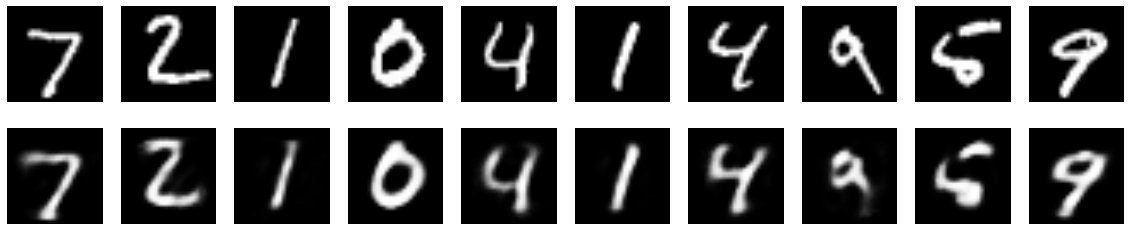

In [8]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding noise to input data

In [9]:
noise_factor = 0.25
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [10]:
encoded_noisy_imgs = encoder.predict(x_test_noisy)
decoded_noisy_imgs = decoder.predict(encoded_noisy_imgs)

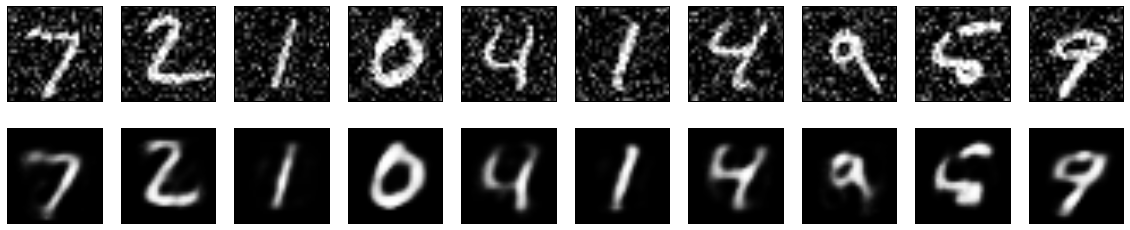

In [11]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()